# Load Libraries

In [1]:
#pip install -r requirements.txt
#conda install joblib

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pycaret.regression import *
import math
import datetime as dt

In [5]:
# Experiment parameters 
TEMPORAL_FEATURES = True
LINEAR_FEATURES = False

# Load & Set Data

In [6]:
train_sales = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/training_Sales.csv")
train_traffic = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/training_Traffic.csv")

**Note:**
We are be predicting per hour, at the moment the data is in intervals of 15mins \
We resample the data at a per hour basis 

In [7]:
train_sales["Date"] = pd.to_datetime(train_sales["Date"])
train_sales = pd.DataFrame(train_sales.resample('H', on='Date').Value.sum())

train_traffic["Date"] = pd.to_datetime(train_traffic["Date"])
train_traffic = pd.DataFrame(train_traffic.resample('H', on='Date').Value.sum())

We create test data, we will set this to 1 month from the last day in train_sales / train_traffic

In [8]:
test_time = np.arange( pd.to_datetime("2018-05-07 00:00:00") , pd.to_datetime("2018-05-08 00:00:00"), dt.timedelta(hours =1))
test = pd.DataFrame(test_time, columns=["Date"])
test.index = test["Date"]
test = test.drop(["Date"], axis =1)

In [9]:
display(train_sales.head())
display(train_traffic.head())
display(test.head())

,Value
Date,
2013-11-07 13:00:00,3457
2013-11-07 14:00:00,2250
2013-11-07 15:00:00,0
2013-11-07 16:00:00,729
2013-11-07 17:00:00,0


,Value
Date,
2015-01-01 10:00:00,8
2015-01-01 11:00:00,14
2015-01-01 12:00:00,28
2015-01-01 13:00:00,33
2015-01-01 14:00:00,47


""
Date
2018-05-07 00:00:00
2018-05-07 01:00:00
2018-05-07 02:00:00
2018-05-07 03:00:00
2018-05-07 04:00:00


#### For ease of use
We will merge the two training datasets 

In [10]:
min(train_traffic.index)

Timestamp('2015-01-01 10:00:00', freq='H')

In [11]:
train = pd.concat([train_sales, train_traffic], axis =1 )
train.columns = ["Sales_Value", "Traffic_Value"]
train.head()

,Sales_Value,Traffic_Value
Date,,
2013-11-07 13:00:00,3457.0,NaN
2013-11-07 14:00:00,2250.0,NaN
2013-11-07 15:00:00,0.0,NaN
2013-11-07 16:00:00,729.0,NaN
2013-11-07 17:00:00,0.0,NaN


 Confirm Traffic values start min date:

In [12]:
train[train["Traffic_Value"].notnull()].index.min()

Timestamp('2015-01-01 10:00:00', freq='H')

# Missing Values 
As per the Exercise Description we have missing values \
We have the basic mean, median and mode imputations however this wont work well for timeseries values. We should therefore use processes that can infer time series values such as: 
* Spline interpolation
* Linear interpolation 
* Supervised learning 

In [13]:
# Set all 0 values for ease of interpolation 
'''train_sales.replace(0,np.NaN,inplace=True)
train_traffic.replace(0,np.NaN,inplace=True)'''

train.replace(0,np.NaN,inplace=True)

In [14]:
'''train_sales.interpolate(method="linear",inplace=True)
train_sales.interpolate(method=MISSING_INTERPOLATE,inplace=True)'''

train.interpolate(method="linear",inplace=True)

### Quick feature extraction 

In [15]:
files = [train, test]

In [16]:
def temporal_extraction(df):
    df["hour"] = df.index.day
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofweek"] = df.index.day_of_week

    df["dayofyear"] = df.index.day_of_year
    df['inverse_dayofyear'] = 365 - df.index.dayofyear
    
    #lets set quarters to a categorical feature as it I suspect this may better for boosting models to use categorical rather than numerical
    df['quarter'] = 'Q' + df.index.quarter.astype(str)
    df["daysinmonth"] = df.index.daysinmonth
    
    return df 

if TEMPORAL_FEATURES: 
    for file in files:
        temporal_extraction(file)

In [17]:
# We will decompose any seasonal pattersn using the  Fourier Series transformation 

def linear_extractions(df):
    for k in range(1,20):
        df[f'sin{k}'] = np.sin(df.index.dayofyear / 365 * 2 * math.pi * k)
        df[f'cos{k}'] = np.cos(df.index.dayofyear / 365 * 2 * math.pi * k)
    return df 

if LINEAR_FEATURES:
    for file in files:
        linear_extractions(file)

In [18]:
train.head()

,Sales_Value,Traffic_Value,hour,day,month,year,dayofweek,dayofyear,inverse_dayofyear,quarter,daysinmonth
Date,,,,,,,,,,,
2013-11-07 13:00:00,3457.0,NaN,7,7,11,2013,3,311,54,Q4,30
2013-11-07 14:00:00,2250.0,NaN,7,7,11,2013,3,311,54,Q4,30
2013-11-07 15:00:00,1489.5,NaN,7,7,11,2013,3,311,54,Q4,30
2013-11-07 16:00:00,729.0,NaN,7,7,11,2013,3,311,54,Q4,30
2013-11-07 17:00:00,1181.0,NaN,7,7,11,2013,3,311,54,Q4,30


# EDA 

In [19]:
sns.set_theme(style ="whitegrid")

In [20]:
print(f"Max Sales date:" ,train_sales.index.max())
print(f"Min Sales date:" ,train_sales.index.min())

print(f"Max Traffic date:" ,train_traffic.index.max())
print(f"Min Traffic date:" ,train_traffic.index.min())

Max Sales date: 2018-05-06 19:00:00
Min Sales date: 2013-11-07 13:00:00
Max Traffic date: 2018-05-06 21:00:00
Min Traffic date: 2015-01-01 10:00:00


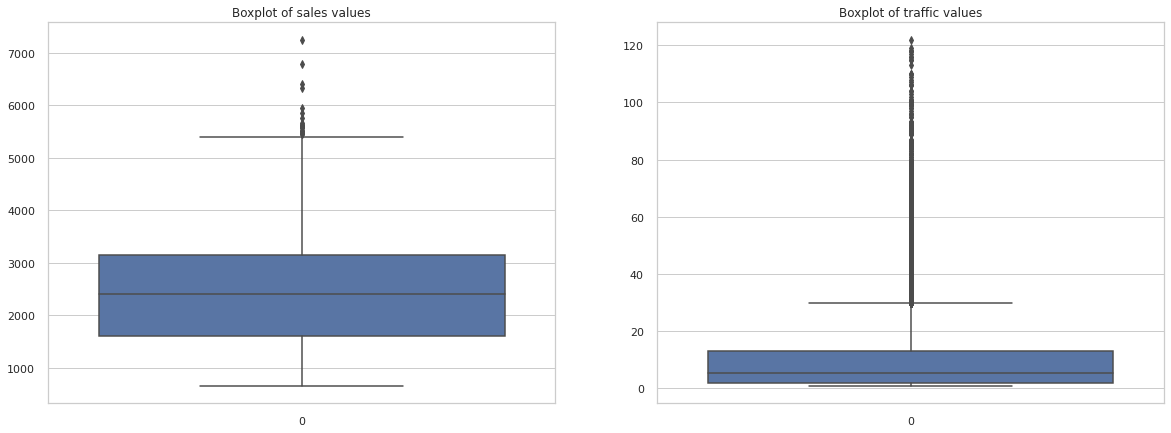

In [21]:
fig,ax = plt.subplots(1,2, figsize=(20,7))
sns.boxplot(ax = ax[0], data = train["Sales_Value"])
ax[0].set_title("Boxplot of sales values")

sns.boxplot(ax = ax[1], data = train["Traffic_Value"])
ax[1].set_title("Boxplot of traffic values")
plt.show()

We have some outlier/s on the **Traffic** data \
**Note**: MinMax scaling may not work well for Traffic values as a result \
**Option**: limit/clip these values as they may throw off the prediction

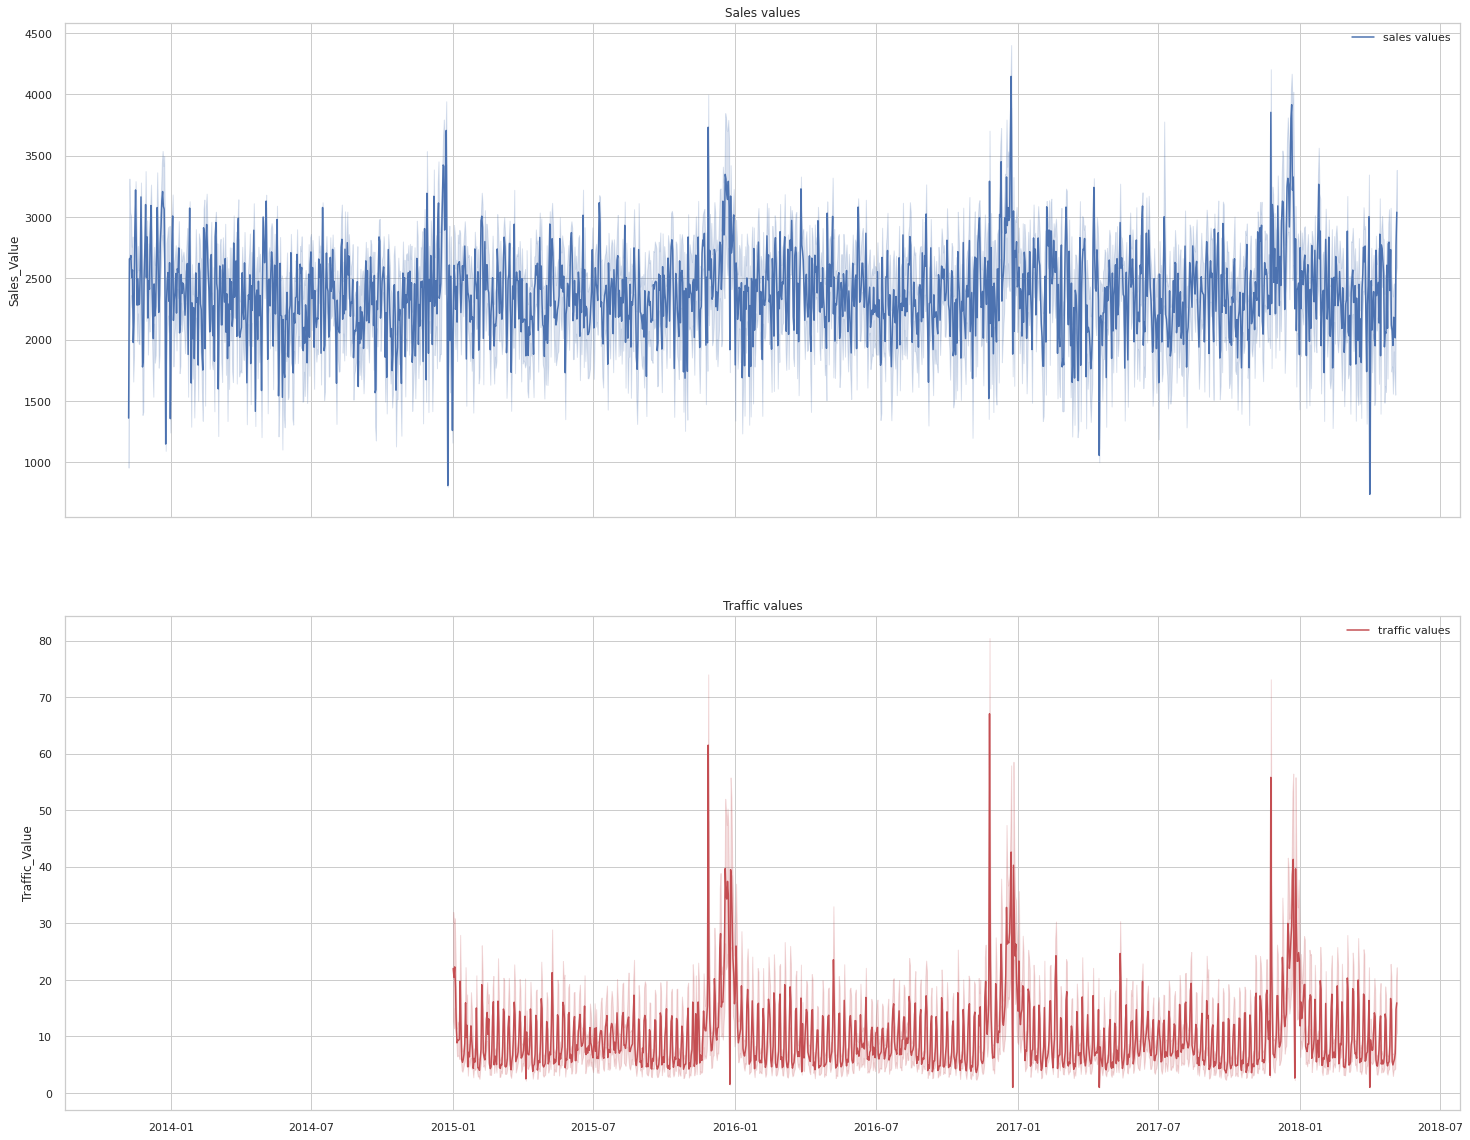

In [37]:
fig,ax = plt.subplots(2,1, figsize=(25,20),sharex= True)

sns.lineplot(ax = ax[0],data = train, x = train.index.date, y = "Sales_Value", label = "sales values", color = "b" )
ax[0].set_title("Sales values")
sns.lineplot(ax = ax[1], data = train, x = train.index.date, y = "Traffic_Value", label = "traffic values", color= "r")
ax[1].set_title("Traffic values")
plt.show()

**Note**:
Definite correlation between traffic and sales values 

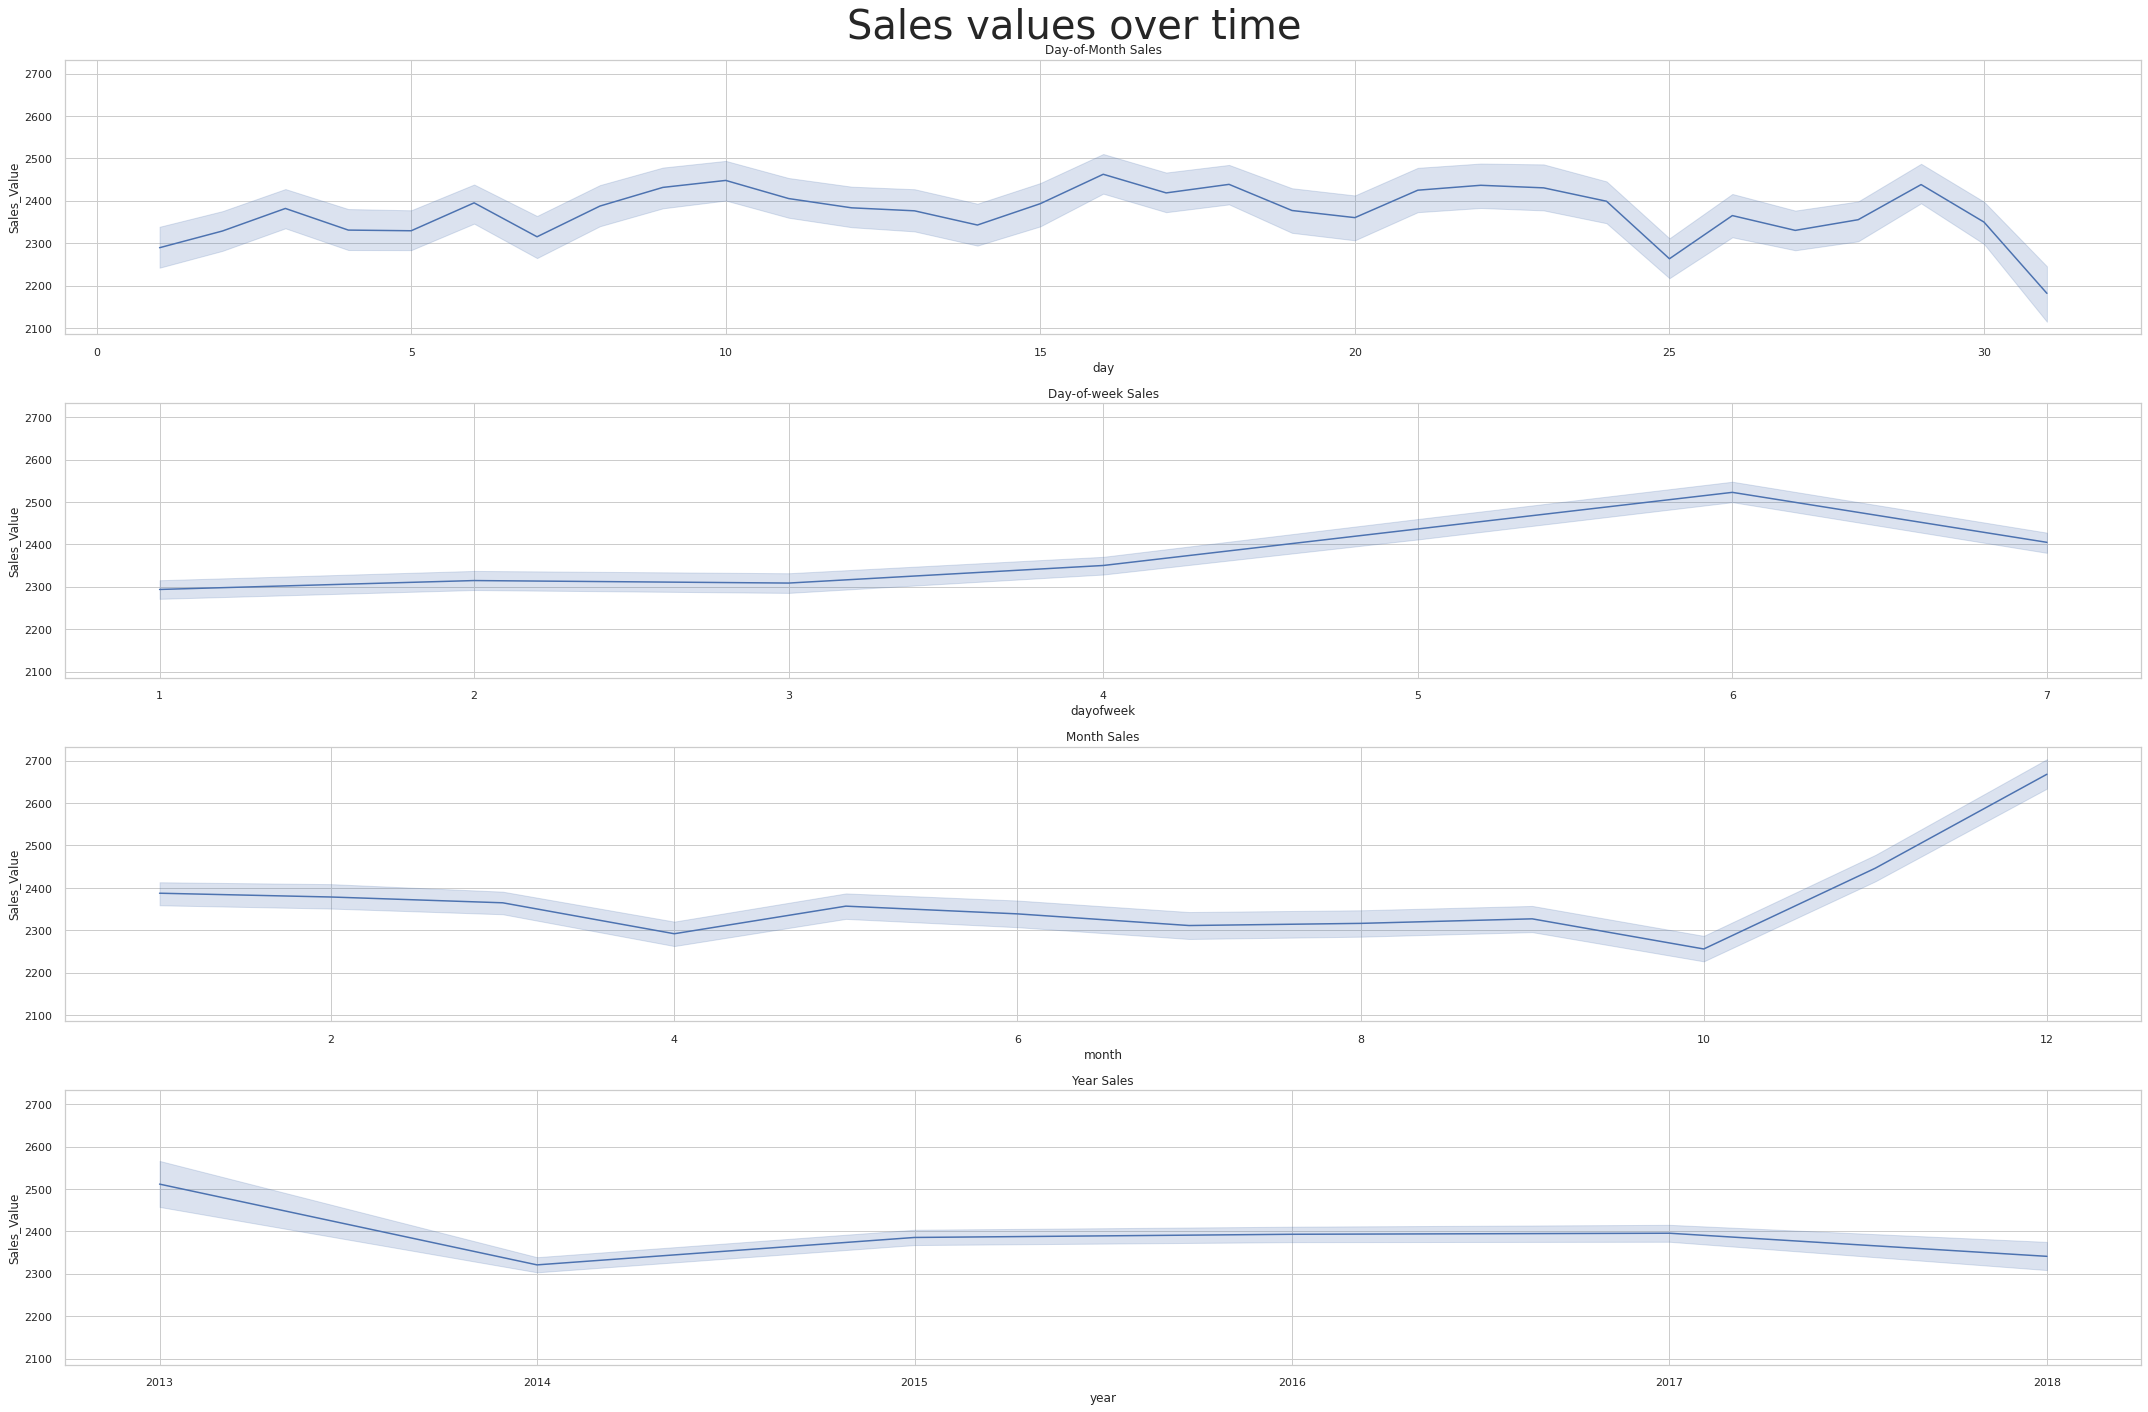

In [23]:
if TEMPORAL_FEATURES:
    fig,ax = plt.subplots(4,1, figsize=(30,20),sharey= True)

    ax[0].set_title("Day-of-Month Sales")
    sns.lineplot(ax=ax[0], data= train, x="day",y="Sales_Value")

    ax[1].set_title("Day-of-week Sales")
    sns.lineplot(ax=ax[1], data= train, x=train["dayofweek"]+1,y="Sales_Value")

    ax[2].set_title("Month Sales")
    sns.lineplot(ax=ax[2], data= train, x="month",y="Sales_Value")

    ax[3].set_title("Year Sales")
    sns.lineplot(ax=ax[3], data= train, x="year",y="Sales_Value")

    fig.suptitle("Sales values over time",fontsize = 40 ) 

    plt.tight_layout()
    plt.show()

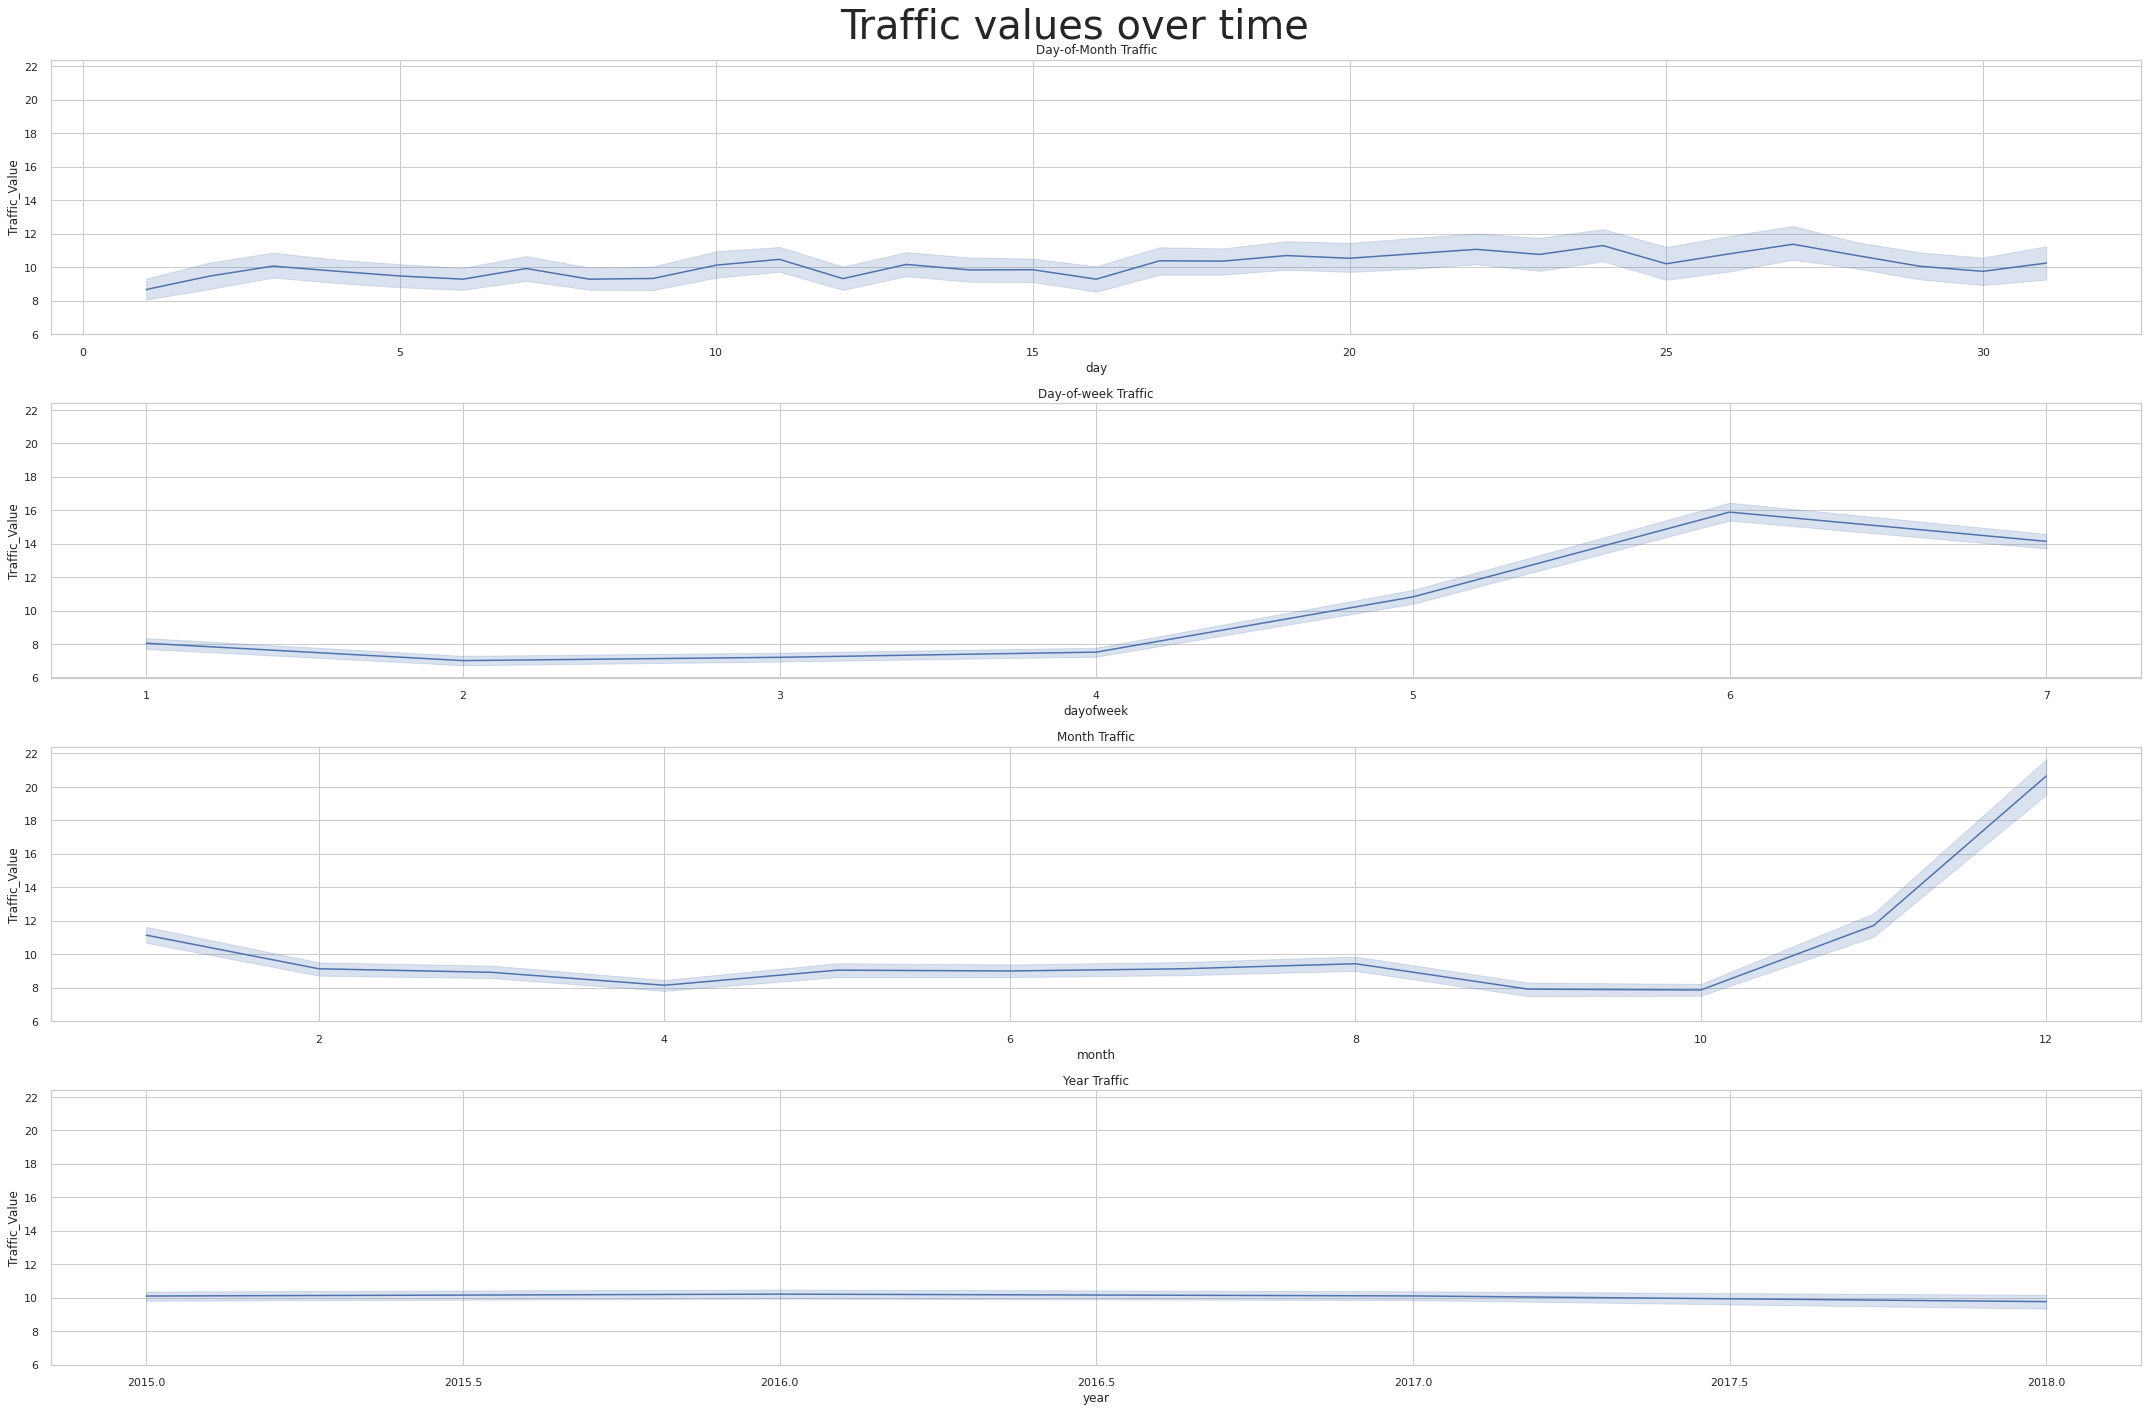

In [24]:
if TEMPORAL_FEATURES:
    fig,ax = plt.subplots(4,1, figsize=(30,20),sharey= True)

    ax[0].set_title("Day-of-Month Traffic")
    sns.lineplot(ax=ax[0], data= train, x="day",y="Traffic_Value")

    ax[1].set_title("Day-of-week Traffic")
    sns.lineplot(ax=ax[1], data= train, x=train["dayofweek"]+1,y="Traffic_Value")

    ax[2].set_title("Month Traffic")
    sns.lineplot(ax=ax[2], data= train, x="month",y="Traffic_Value")

    ax[3].set_title("Year Traffic")
    sns.lineplot(ax=ax[3], data= train, x="year",y="Traffic_Value")

    fig.suptitle("Traffic values over time",fontsize = 40 ) 

    plt.tight_layout()
    plt.show()

# Baseline Sales Model  - Pycaret 

In [25]:
train.sort_index(inplace=True)

In [26]:
reg_sales = setup(train, target = 'Sales_Value', session_id=1, log_experiment=True, experiment_name='Sales Baseline',silent=True)

,Description,Value
0,session_id,1
1,Target,Sales_Value
2,Original Data,"(39393, 11)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(27575, 36)"


In [27]:
model_sales = compare_models(fold=5,sort = 'RMSE',)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,466.9693,378450.2562,615.1681,0.5303,0.3414,0.2846,12.3420
rf,Random Forest Regressor,452.0489,380706.7308,616.9990,0.5275,0.3358,0.2697,3.3320
catboost,CatBoost Regressor,477.3405,384875.9746,620.3652,0.5224,0.3469,0.2936,3.0160
et,Extra Trees Regressor,444.9717,389395.1708,623.9906,0.5167,0.3373,0.2620,3.4940
lightgbm,Light Gradient Boosting Machine,492.8762,403696.3909,635.3589,0.4990,0.3575,0.3067,0.1420
knn,K Neighbors Regressor,463.6230,408522.0500,639.1052,0.4929,0.3445,0.2730,0.1380
gbr,Gradient Boosting Regressor,527.6899,452082.7702,672.3606,0.4390,0.3789,0.3320,1.0740
dt,Decision Tree Regressor,501.0937,502212.9795,708.5812,0.3767,0.3841,0.2900,0.0920
lr,Linear Regression,618.6351,557338.9625,746.5389,0.3085,0.4084,0.3817,0.5700
lasso,Lasso Regression,619.0448,557863.5875,746.8914,0.3078,0.4088,0.3822,0.0440


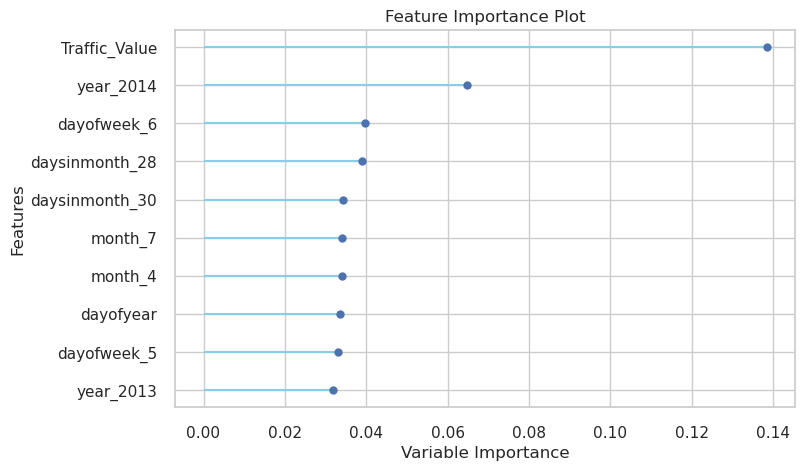

In [28]:
plot_model(model_sales, plot='feature')

In [29]:
reg_traffic = setup(train, target = 'Traffic_Value', session_id=1, log_experiment=True, experiment_name='Sales Baseline',silent=True)

,Description,Value
0,session_id,1
1,Target,Traffic_Value
2,Original Data,"(39393, 11)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(20516, 34)"


In [30]:
model_sales = compare_models(fold=5,sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.5277,31.9163,5.6491,0.8040,0.5472,0.9002,2.3080
lightgbm,Light Gradient Boosting Machine,3.6065,32.7043,5.7182,0.7991,0.5583,0.9383,0.1220
xgboost,Extreme Gradient Boosting,3.5956,34.3082,5.8563,0.7894,0.5449,0.8806,10.9360
rf,Random Forest Regressor,3.4827,35.2700,5.9380,0.7834,0.5236,0.8082,3.1220
gbr,Gradient Boosting Regressor,3.8792,36.9340,6.0771,0.7731,0.5927,1.0299,0.9080
et,Extra Trees Regressor,3.4924,38.0546,6.1677,0.7663,0.5284,0.7491,2.6760
knn,K Neighbors Regressor,4.6446,57.5101,7.5823,0.6470,0.6442,1.0604,0.0960
ada,AdaBoost Regressor,5.8551,59.6421,7.7185,0.6330,0.8489,2.1026,0.2800
dt,Decision Tree Regressor,4.5460,65.1231,8.0671,0.6002,0.6848,0.9011,0.0900
lr,Linear Regression,6.3517,85.0209,9.2199,0.4779,0.8482,2.1393,0.0320


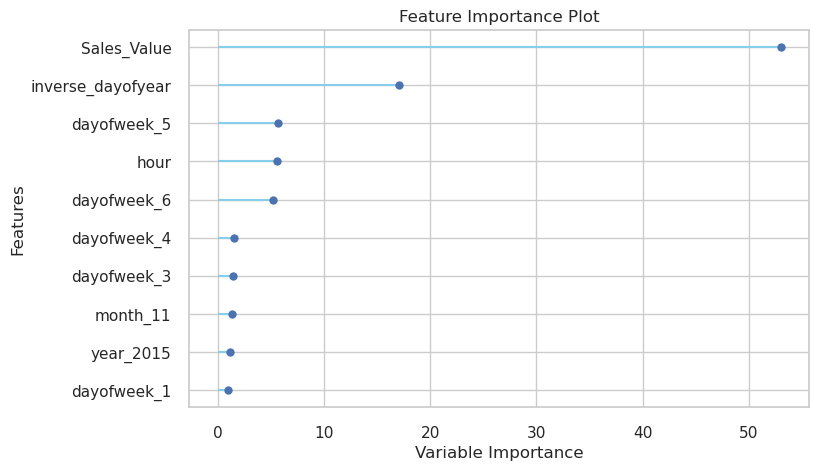

In [31]:
plot_model(model_sales, plot='feature')

# Prediction - Baseline

In [32]:
preds_train =  predict_model(model_sales, train)

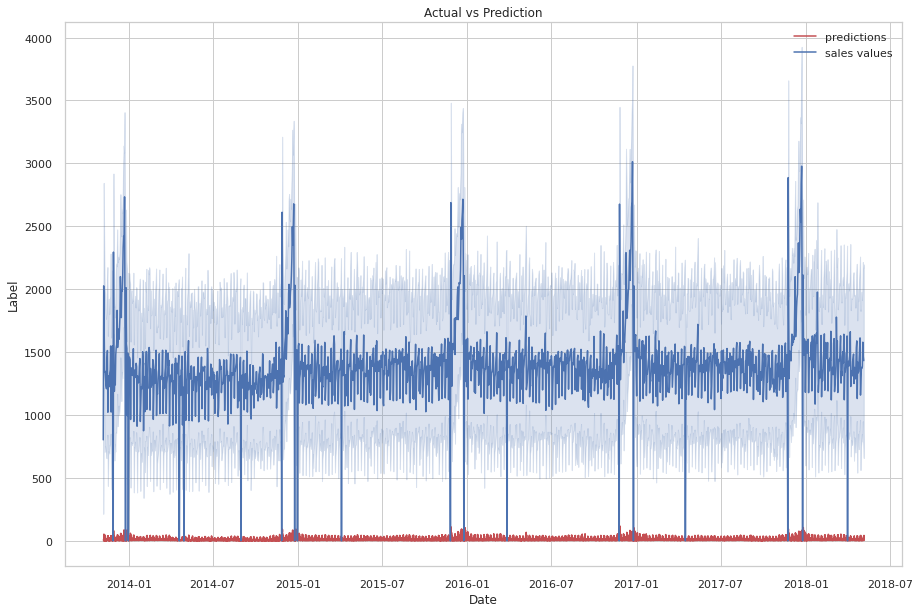

In [33]:
plt.figure(figsize=(15,10))
sns.lineplot(data = preds_train["Label"], label = "predictions", color = "r" )
sns.lineplot(data = train_sales, x = train_sales.index.date, y = "Value", label = "sales values", color = "b" )
plt.title("Actual vs Prediction")

plt.show()

In [34]:
residuals = train_sales["Value"] - preds_train["Label"]

In [35]:
residuals.head()

Date
2013-11-07 13:00:00    3445.087661
2013-11-07 14:00:00    2246.811921
2013-11-07 15:00:00      -0.506359
2013-11-07 16:00:00     727.161800
2013-11-07 17:00:00       0.030058
Freq: H, dtype: float64

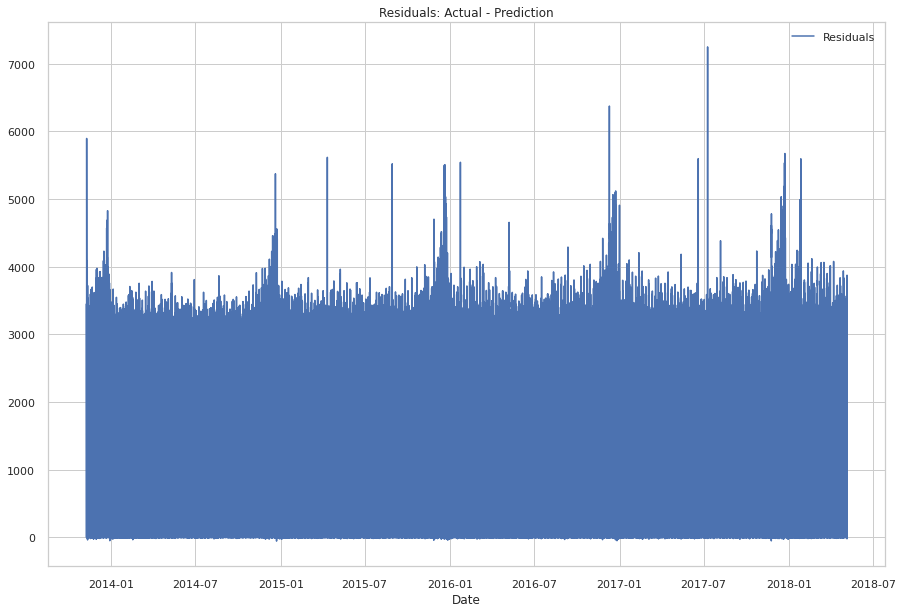

In [36]:
plt.figure(figsize=(15,10))
sns.lineplot(data = residuals, label = "Residuals", color = "b" )
plt.title("Residuals: Actual - Prediction")

plt.show()